In [4]:
import numpy
import time
from tqdm import tqdm
import ipyparallel as ipp
from scipy import stats
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.problems.second_quantization.electronic.builders import fermionic_op_builder
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
#from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit.opflow import I,X,Y,Z,StateFn,AbelianGrouper
from qiskit.chemistry import FermionicOperator
from qiskit.providers.aer import AerSimulator
from qiskit.aqua.operators.legacy import op_converter
from openfermion.circuits import slater_determinant_preparation_circuit
from qiskit.quantum_info import Pauli
from qiskit import QuantumCircuit,execute,QuantumRegister,ClassicalRegister
from qiskit import Aer
from openfermion.linalg import givens_decomposition_square as givensRotns
from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler, CircuitStateFn 
import scipy
from joblib import Parallel, delayed, Memory
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.compiler import transpile
from qiskit.circuit.random import random_circuit
from qiskit.chemistry.components.variational_forms import UCCSD

In [40]:
U=7
E_arr=[]
params_arr=[]
num_shots_arr=[2**3,2**4,2**4]
string_shots_label=','.join([str(shots) for shots in num_shots_arr])
with open('../'+str(U)+'/adaDeltaOptStepsWithQasm'+string_shots_label+'.txt','r') as f:
    lines=f.readlines()
    for line in lines:
        elems=line.split('#')
        E_arr.append(float(elems[1]))
        params_arr.append(eval(elems[0]))
E_arr1=[]
params_arr1=[]
num_shots_arr=[2**2,2**3,2**3]
string_shots_label=','.join([str(shots) for shots in num_shots_arr])
with open('../'+str(U)+'/adaDeltaOptStepsWithQasm'+string_shots_label+'.txt','r') as f:
    lines=f.readlines()
    for line in lines:
        elems=line.split('#')
        E_arr1.append(float(elems[1]))
        params_arr1.append(eval(elems[0]))        

In [42]:
params_arr1[:95],E_arr1[:95]

([[0.02244790412005553],
  [0.04540603706047969],
  [0.0644986093519679],
  [0.08637206524724521],
  [0.1046493469009642],
  [0.12232262182908035],
  [0.14318115705970724],
  [0.1553175490569433],
  [0.16803555185388153],
  [0.18022108642498813],
  [0.18758921294231184],
  [0.19877989454538972],
  [0.21180457881032885],
  [0.2147885514613585],
  [0.2262221813106184],
  [0.2359125022291438],
  [0.23824836183646586],
  [0.23880182014802354],
  [0.2421097327852957],
  [0.24532887155483823],
  [0.24753701805619172],
  [0.2525952861738407],
  [0.2552969137129398],
  [0.25265218013753754],
  [0.25692171892365895],
  [0.25809292305367454],
  [0.2602401081442577],
  [0.2596507849502199],
  [0.2586266840884215],
  [0.26234107161169085],
  [0.2611274775225381],
  [0.26170754685995967],
  [0.26407503452530884],
  [0.2577024365005452],
  [0.25844187493446236],
  [0.2601187827268393],
  [0.26493456373571467],
  [0.2664188130558529],
  [0.26456747828086014],
  [0.2653731335311764],
  [0.266186646171

In [7]:
import warnings
warnings. filterwarnings('ignore')

In [8]:
c = ipp.Client()
num_qubits=8
c.ids

[0, 1, 2, 3, 4, 5, 6, 7]

In [9]:
def qubitOp(h1,h2):
    qubit_op=FermionicOperator(h1,h2).mapping('jordan_wigner')
    return qubit_op

In [10]:
def egBandHamiltonian(U):
    #Getting chemical Potential for Half-Filling
    with open('../chem_pot_for_Half_Fill.txt','r') as f:
        lines=f.readlines()[1:]
        for line in lines:
            elems=line.split()
            if int(elems[0])==U:
                muHalf=float(elems[1]) #Chem Pot for a given Hubbard U
    #Getting the one body and two body interaction vertexes
    with open('../'+str(U)+'/v1e.dat','r') as f:
            lines=f.readlines()[1:]
            num_sites=4
            chem_pot=numpy.zeros((2*num_sites,2*num_sites))
            eg_h1=numpy.zeros((2*num_sites,2*num_sites))
            for line in lines:
                elems=line.split()
                eg_h1[int(elems[0])][int(elems[1])]=float(elems[2])
                eg_h1[int(elems[0])+num_sites][int(elems[1])+num_sites]=float(elems[2])
            for i in range(2*num_sites):
                chem_pot[i][i]=-muHalf
            eg_h1=eg_h1+chem_pot       
    with open('../'+str(U)+'/v2e.dat','r') as f:
        num_sites=4
        eg_h2=numpy.zeros((2*num_sites,2*num_sites,2*num_sites,2*num_sites))
        for line in f:
            if "#" in line:
                continue
            line = line.split()
            i,j,k,l = map(int, line[:4])
            val = float(line[4])
            eg_h2[i,j,k,l] = eg_h2[i+num_sites,j+num_sites,k,l] = eg_h2[i,j,k+num_sites,l+num_sites] \
            = eg_h2[i+num_sites,j+num_sites,k+num_sites,l+num_sites] = 0.5*val  # convention with 0.5 factor included.
    qubitH=qubitOp(eg_h1,eg_h2)
    Hmat=op_converter.to_matrix_operator(qubitH).dense_matrix
    w,v=numpy.linalg.eigh(Hmat)
    Eg=w[0]
    state_g=v[:,0]
    return qubitH,Hmat,Eg,state_g

In [11]:
%run Utils.ipynb
%run optimizers.ipynb
%run EstimateHamiltonianMean.ipynb

In [12]:
U=7
qubitH,Hmat,Eg,state_g=egBandHamiltonian(U)

In [13]:
#Hamiltonian grouping for circuit based measurement
eg_h1_0,eg_h1_1,eg_h2_0,eg_h2_1=egBandHamiltonianPartition(U)
qubitH_0,qubitH_1,qubitH_2=qubitHamiltonianGroups(U)
opArr=[qubitH_0,qubitH_1,qubitH_2]
#two body off diags
circ0_1gate,rotH2body=OffDiag2BodyTerms(opArr[2])
#one body off diags
circ0_8gate,rotH1body=OffDiag1BodyTerms(opArr[0])
Ops=[rotH1body,opArr[1],rotH2body]

In [19]:
U=7
backend=Aer.get_backend('statevector_simulator')
HFcirc,HFstate=HF_init_state(U)
var_form_base=UCCSD(8,num_particles=4, initial_state=HFcirc,qubit_mapping='jordan_wigner',two_qubit_reduction=False)
var_form_base.manage_hopping_operators()

Final Hartree Fock Energy -18.788335371650774


In [18]:
Labels=[]
with open('../'+str(U)+'/labels_AdaDelta.txt','r') as f:
    lines=f.readlines()
    for line in lines:
        Labels.append(line[:-1])

In [20]:
var_form_base.push_hopping_operator(WeightedPauliOperator([[1j,Pauli.from_label(Labels[0])]]))

In [21]:
ang=numpy.linspace(0,numpy.pi/6,50)
E_Landscape_arr=[Energy([ang[i]]) for i in tqdm(range(len(ang)))]

100%|██████████| 50/50 [00:04<00:00, 12.02it/s]


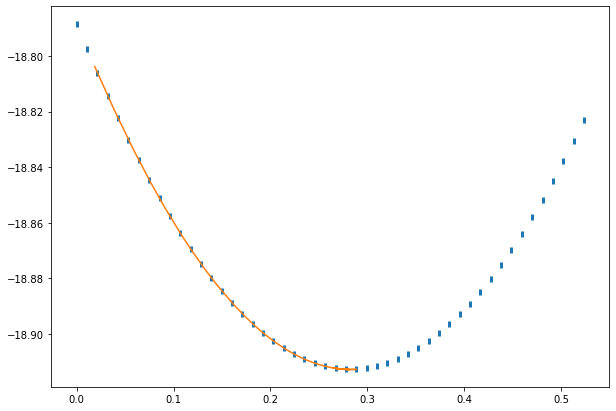

In [28]:
import matplotlib.pyplot as plt
figure,ax=plt.subplots(1,figsize=(10,7))
ax.plot(ang,E_Landscape_arr,linestyle='',marker='|',markersize=6,markeredgewidth=3)
ax.plot(params_arr[:91],E_arr[:91],linestyle='-')

In [30]:
var_form_base.push_hopping_operator(WeightedPauliOperator([[1j,Pauli.from_label(Labels[1])]]))

In [38]:
ang1=numpy.linspace(0.15,0.4,20)
ang2=numpy.linspace(0.0,0.4,20)
E_landscape_arr2=[[Energy([ang1[i],ang2[j]]) for i in range(len(ang1))] for j in tqdm(range(len(ang2)))]


  0%|          | 0/20 [07:44<?, ?it/s]

100%|██████████| 20/20 [02:42<00:00,  8.13s/it]


In [36]:
params_arr[90]

[0.2792904366745955]

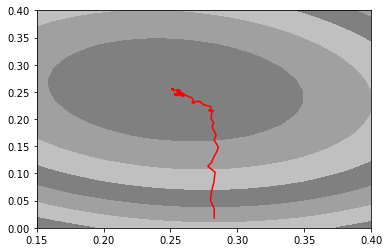

In [39]:

cs = plt.contourf(ang1,ang2,E_landscape_arr2,colors=['#808080', '#A0A0A0', '#C0C0C0'])
plt.plot(numpy.array(params_arr[91:])[:,0],numpy.array(params_arr[91:])[:,1],color='r')

In [38]:
params_arr[100:]

[[0.27957264060801995, 0.010332666781715754],
 [0.28134177290823964, 0.020058718464259676],
 [0.2807311970702514, 0.02627163835976755],
 [0.27990874181018155, 0.03479662239582343],
 [0.27840358363945134, 0.04310634428537521],
 [0.27981243636802433, 0.05241026888577052],
 [0.2794760543381806, 0.05993140878580144],
 [0.2777333601110278, 0.06980195450466128],
 [0.2765208695146541, 0.08153214665385486],
 [0.2750248691606435, 0.08598085429248467],
 [0.27649842616468795, 0.09261448605624427],
 [0.2754142673143918, 0.10027392769296262],
 [0.27639456653573674, 0.1097419922442442],
 [0.2739001633717931, 0.11610786873165996],
 [0.2712470234083165, 0.1192409486188181],
 [0.2708881739371999, 0.1254782139009952],
 [0.26928814404346235, 0.13287101729965398],
 [0.2730613583280772, 0.1364783395627277],
 [0.2708561530358754, 0.14318323624945165],
 [0.26753963424153027, 0.15166511283903142],
 [0.269041507787241, 0.15844504836630408],
 [0.2694078198646092, 0.16262060101300813],
 [0.2702332690860716, 0.16

In [ ]:
import matplotlib.pyplot as plt
figure,ax=plt.subplots(1,figsize=(10,7))
ax.plot(ang,E_Landscape_arr,linestyle='',marker='|',markersize=6,markeredgewidth=3)
ax.plot(params_arr[:99],E_arr[:99],linestyle='-')